In [1]:
import requests
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas_datareader.data as web
import numpy as np

Edit tickers, target and datetime is necessary.

In [2]:
tickers = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'TWTR', '^GSPC'] 
target = ''
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()
#end = dt.datetime(2021, 1, 1)

main_df = pd.DataFrame
for ticker in tickers:
  if ticker not in target: 
    df = web.DataReader(ticker, 'yahoo', start, end)
    df = df[['Adj Close']]
    df.rename(columns={'Adj Close': ticker}, inplace=True)
    if main_df.empty: 
      main_df = df
    else: 
      main_df = main_df.join(df, how='outer')

price_df = main_df
price_df.reset_index(level=0,inplace=True)
price_df.head()

,Date,AAPL,AMZN,TSLA,GOOG,TWTR,^GSPC
0,2015-01-02,24.861401,308.519989,43.862000,523.373108,36.560001,2058.199951
1,2015-01-05,24.161013,302.190002,42.018002,512.463013,36.380001,2020.579956
2,2015-01-06,24.163294,295.290009,42.256001,500.585632,38.759998,2002.609985
3,2015-01-07,24.502111,298.420013,42.189999,499.727997,37.279999,2025.900024
4,2015-01-08,25.443539,300.459991,42.124001,501.303680,39.090000,2062.139893


In [3]:
tickers = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'TWTR', '^GSPC'] 
target = ''
start = dt.datetime(2015, 1, 1)
end = dt.datetime.now()
#end = dt.datetime(2021, 1, 1)

main_df = pd.DataFrame
for ticker in tickers:
  if ticker not in target: 
    df = web.DataReader(ticker, 'yahoo', start, end)
    df = df[['Volume']]
    df.rename(columns={'Volume': ticker}, inplace=True)
    if main_df.empty: 
      main_df = df
    else: 
      main_df = main_df.join(df, how='outer')

main_df.head()

volume_df = main_df
volume_df.reset_index(level=0, inplace=True)
volume_df.head()

,Date,AAPL,AMZN,TSLA,GOOG,TWTR,^GSPC
0,2015-01-02,212818400.0,2783200,23822000.0,1447563.0,12062500,2708700000
1,2015-01-05,257142000.0,2774200,26842500.0,2059840.0,15062700,3799120000
2,2015-01-06,263188400.0,3519000,31309500.0,2899940.0,33050800,4460110000
3,2015-01-07,160423600.0,2640300,14842000.0,2065054.0,22675700,3805480000
4,2015-01-08,237458000.0,3088400,17212500.0,3353582.0,19190400,3934010000


# Ridge Regression
Predict future price using previous prices and volume


Ridge Regression works by avoiding overfitting and helps by adjusting weights or biases to improve generalization 

In [4]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
import os

In [5]:
volume_df.info()
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1583 non-null   datetime64[ns]
 1   AAPL    1583 non-null   float64       
 2   AMZN    1583 non-null   int64         
 3   TSLA    1583 non-null   float64       
 4   GOOG    1583 non-null   float64       
 5   TWTR    1583 non-null   int64         
 6   ^GSPC   1583 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 86.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1583 non-null   datetime64[ns]
 1   AAPL    1583 non-null   float64       
 2   AMZN    1583 non-null   float64       
 3   TSLA    1583 non-null   float64       
 4   GOOG    1583 non-null   float64       
 5   TWTR    1

In [10]:
#sentiment = pd.read_csv('AMZN_avg_sent.csv')

FileNotFoundError: [Errno 2] File AMZN_avg_sent.csv does not exist: 'AMZN_avg_sent.csv'

## Visualizations

In [72]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x


# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [73]:
#GIVING ME SOME ERRORS

# plot interactive chart for stocks data
#interactive_plot(price_df, 'Stock Prices')

## Splitting Data into Train and Test

In [74]:
# Function to concatenate the date, stock price, and volume in one dataframe
def individual_stock(price_df, vol_df, name):
    return pd.DataFrame({'Date': price_df['Date'], 'Close': price_df[name], 'Volume': vol_df[name]})

In [75]:
# Function to return the input/output (target) data for AI/ML Model
# Note that our goal is to predict the future stock price 
# Target stock price today will be tomorrow's price 
def trading_window(data):
  
  # 1 day window 
  n = 1

  # Create a column containing the prices for the next 1 days
  data['Target'] = data[['Close']].shift(-n)
  
  # return the new dataset 
  return data

In [76]:
price_volume_df = individual_stock(price_df, volume_df, 'AMZN')
price_volume_df 

,Date,Close,Volume
0,2015-01-02,308.519989,2783200
1,2015-01-05,302.190002,2774200
2,2015-01-06,295.290009,3519000
3,2015-01-07,298.420013,2640300
4,2015-01-08,300.459991,3088400
...,...,...,...
1577,2021-04-09,3372.199951,4334600
1578,2021-04-12,3379.389893,3281800
1579,2021-04-13,3400.000000,3315800
1580,2021-04-14,3333.000000,3140300


In [66]:
price_volume_target_df = trading_window(price_volume_df)

# Remove the last row as it will be a null value
price_volume_target_df = price_volume_target_df[:-1]
price_volume_target_df

,Date,Close,Volume,Target
0,2015-01-02,308.519989,2783200,302.190002
1,2015-01-05,302.190002,2774200,295.290009
2,2015-01-06,295.290009,3519000,298.420013
3,2015-01-07,298.420013,2640300,300.459991
4,2015-01-08,300.459991,3088400,296.929993
...,...,...,...,...
1576,2021-04-08,3299.300049,2812100,3372.199951
1577,2021-04-09,3372.199951,4334600,3379.389893
1578,2021-04-12,3379.389893,3281800,3400.000000
1579,2021-04-13,3400.000000,3315800,3333.000000


In [67]:
# Scale the data
# Scale the data is 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
price_volume_target_scaled_df = sc.fit_transform(price_volume_target_df.drop(columns = ['Date']))

In [68]:
# Creating Feature and Target
X = price_volume_target_scaled_df[:,:2]  #features are x 
y = price_volume_target_scaled_df[:,2:]  #target are y 

In [69]:
#80% of data is used for training other 20% is used for testing
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

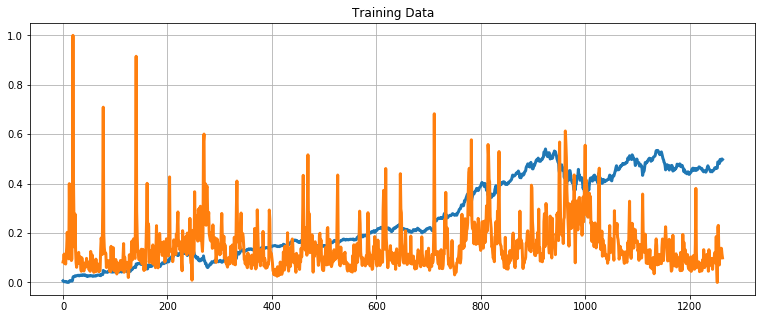

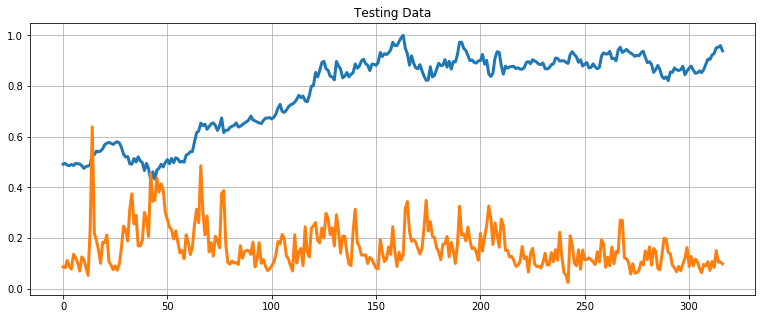

In [70]:
# Define a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')




In [42]:
from sklearn.linear_model import Ridge
# Note that Ridge regression performs linear least squares with L2 regularization.
# Create and train the Ridge Linear Regression  Model
regression_model = Ridge()
regression_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [43]:
# Test the model and calculate its accuracy 
lr_accuracy = regression_model.score(X_test, y_test)
print("Linear Regression Score: ", lr_accuracy)

Linear Regression Score:  0.9748528760574436


In [44]:
# Make Prediction
predicted_prices = regression_model.predict(X)
predicted_prices

array([[0.01421208],
       [0.01231749],
       [0.01037123],
       ...,
       [0.93272359],
       [0.938893  ],
       [0.91882704]])

In [45]:
# Append the predicted values into a list
Predicted = []
for i in predicted_prices:
  Predicted.append(i[0])

In [46]:
len(Predicted)

1581

In [47]:
# Append the close values to the list
close = []
for i in price_volume_target_scaled_df:
  close.append(i[0])

In [48]:
# Create a dataframe based on the dates in the individual stock data
df_predicted = price_volume_target_df[['Date']]
df_predicted

,Date
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08
...,...
1576,2021-04-08
1577,2021-04-09
1578,2021-04-12
1579,2021-04-13


In [49]:
# Add the close values to the dataframe
df_predicted['Close'] = close
df_predicted

,Date,Close
0,2015-01-02,0.006648
1,2015-01-05,0.004697
2,2015-01-06,0.002571
3,2015-01-07,0.003535
4,2015-01-08,0.004164
...,...,...
1576,2021-04-08,0.928448
1577,2021-04-09,0.950917
1578,2021-04-12,0.953133
1579,2021-04-13,0.959485


In [50]:
# Add the predicted values to the dataframe
df_predicted['Prediction'] = Predicted
df_predicted

,Date,Close,Prediction
0,2015-01-02,0.006648,0.014212
1,2015-01-05,0.004697,0.012317
2,2015-01-06,0.002571,0.010371
3,2015-01-07,0.003535,0.011169
4,2015-01-08,0.004164,0.011850
...,...,...,...
1576,2021-04-08,0.928448,0.908696
1577,2021-04-09,0.950917,0.930739
1578,2021-04-12,0.953133,0.932724
1579,2021-04-13,0.959485,0.938893


In [51]:
# Plot the results
#df_predicted, "Original Vs. Prediction")

df_predicted.set_index('Date')
df_predicted['Deviation'] = (df_predicted['Close'] - df_predicted['Prediction'])**2

df_predicted


,Date,Close,Prediction,Deviation
0,2015-01-02,0.006648,0.014212,0.000057
1,2015-01-05,0.004697,0.012317,0.000058
2,2015-01-06,0.002571,0.010371,0.000061
3,2015-01-07,0.003535,0.011169,0.000058
4,2015-01-08,0.004164,0.011850,0.000059
...,...,...,...,...
1576,2021-04-08,0.928448,0.908696,0.000390
1577,2021-04-09,0.950917,0.930739,0.000407
1578,2021-04-12,0.953133,0.932724,0.000417
1579,2021-04-13,0.959485,0.938893,0.000424


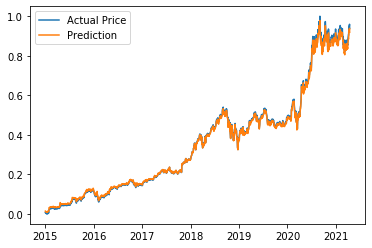

In [52]:
plt.plot(df_predicted['Date'],df_predicted['Close'], label = "Actual Price")
plt.plot(df_predicted['Date'],df_predicted['Prediction'], label = 'Prediction')


plt.legend()
plt.show()

In [53]:
df_predicted_test = df_predicted.loc[split:]

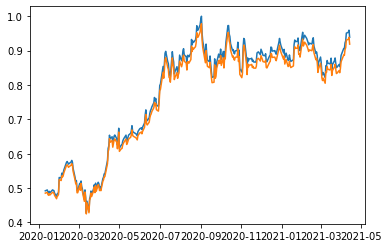

In [54]:


plt.plot(df_predicted_test['Date'],df_predicted_test['Close'], label = "Actual Price")
plt.plot(df_predicted_test['Date'],df_predicted_test['Prediction'], label = 'Prediction')


split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

# Model LSTM
### LSTM uses neural networks to extrapolate to learn from long term dependencies
### It can not only process single data points but entire sequences of data

In [21]:
#Uses training set and extracts variables for model
target_df.head()
training_set = target_df.iloc[:, 1:2].values

In [25]:
#Scale our data for optimal performance
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

In [26]:
target_df.head()

,High,Low,Open,Close,Volume,Adj Close,Moving_av,Increase_in_vol,Increase_in_adj_close
Date,,,,,,,,,
2015-01-02,314.750000,306.959991,312.579987,308.519989,2783200,308.519989,308.519989,0.0,0.000000
2015-01-05,308.380005,300.850006,307.010010,302.190002,2774200,302.190002,305.354996,-9000.0,-6.329987
2015-01-06,303.000000,292.380005,302.239990,295.290009,3519000,295.290009,302.000000,744800.0,-6.899994
2015-01-07,301.279999,295.329987,297.500000,298.420013,2640300,298.420013,301.105003,-878700.0,3.130005
2015-01-08,303.140015,296.109985,300.320007,300.459991,3088400,300.459991,300.976001,448100.0,2.039978


Execute to convert data into a numpy array, and split it between the train and test data. And to set the predicition labels, the y-values, as the 'Open' value for the target stock.



In [5]:
y = main_df[['Open']]
y = y.to_numpy()
X = main_df.drop(['Open'], axis=1)
X = X.to_numpy()
# data = main_df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [13]:
X

array([[ 2.48614006e+01,  4.38619995e+01,  5.23373108e+02, ...,
         3.08519989e+02,  0.00000000e+00,  0.00000000e+00],
       [ 2.41610126e+01,  4.20180016e+01,  5.12463013e+02, ...,
         3.05354996e+02, -9.00000000e+03, -6.32998657e+00],
       [ 2.41632938e+01,  4.22560005e+01,  5.00585632e+02, ...,
         3.02000000e+02,  7.44800000e+05, -6.89999390e+00],
       ...,
       [ 1.34668762e+02,  6.65989990e+02,  1.75871997e+03, ...,
         3.17074299e+03, -8.13900000e+05,  3.80400391e+01],
       [ 1.33520477e+02,  6.94780029e+02,  1.73952002e+03, ...,
         3.17231580e+03, -1.66360000e+06, -3.61499023e+01],
       [ 1.32492020e+02,  7.05669983e+02,  1.75188000e+03, ...,
         3.17311419e+03, -2.52100000e+05, -2.89201660e+01]])

# Model time!

Now we create and select our features for our target stock.

Features stored/created:

* Adjusted Close	
* Moving average	
* Increase in volume	
* Increase in adjusted close


Execute to join the target stock's features with the other tickers specified earlier.

In [4]:
main_df = main_df.join(target_df, how='outer')

In [3]:
target_df = web.DataReader(target, 'yahoo', start, end)

#calculate the moving average for a feature
target_df['Moving_av'] = target_df['Adj Close'].rolling(window=50, min_periods=0).mean()

#Calculate the rate of increase in volume and rate of increase in adjusted close 
i = 1
rate_increase_in_vol = [0]
rate_increase_in_adj_close = [0]

while i < len(target_df):
    rate_increase_in_vol.append(target_df.iloc[i]['Volume']-target_df.iloc[i - 1]['Volume'])
    rate_increase_in_adj_close.append(target_df.iloc[i]['Adj Close']-target_df.iloc[i - 1]['Adj Close'])
    i += 1

target_df['Increase_in_vol'] = rate_increase_in_vol
target_df['Increase_in_adj_close'] = rate_increase_in_adj_close    

In [16]:
import tensorflow as tf
from keras.models import Sequential

ModuleNotFoundError: No module named 'tensorflow'

Where we can play around with the layers, and activation functions

In [90]:
N,D = X.shape

model = Sequential([
    tf.keras.layers.InputLayer((D,)),
    #layer1
    #layer2
    #....


    #layer L
    tf.keras.layers.Dense(1, activation='sigmoid'),
])